In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math

In [115]:
WN = np.array([[0.25,0.5,0.25],
               [0.5,0.1,0.4],
               [0.25,0.4,0.35]])
pop = np.array([100,60,120])

In [4]:
### One ensemble

In [116]:
num_fips = len(pop)
T = 10

it covers 99.29040524284376 % of the values
7.0959475715624e-05 compare with the last prob 6.778543241544144e-05
it covers 99.94793690833258 % of the values
5.206309166742029e-06 compare with the last prob 2.4979978105066747e-05
it covers 99.99999999999976 % of the values
2.4424906541753444e-17 compare with the last prob 9.755654775956703e-16
it covers 100.0 % of the values
0.0 compare with the last prob 3.3891205435755526e-42
it covers 100.0 % of the values
0.0 compare with the last prob 2.6619580973154302e-58
it covers 99.99999999999999 % of the values
1.1102230246251566e-18 compare with the last prob 4.946889715640957e-93


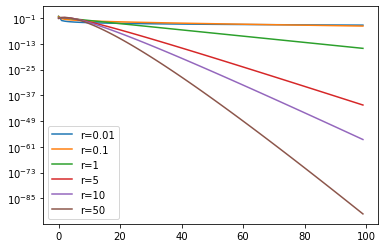

In [13]:
x_cutoff = 100
R0 = 2.5  ## the model input
for r in [0.01,0.1,1,5,10,50]:

#     r = 50 ## parameters (in the paper of Lloyd smith is the k) 0.1 to start 

    p = r/(R0+r)

    weights = np.zeros(x_cutoff)
    for i in range(x_cutoff):
        temp1=SS.gamma(r+i)/SS.gamma(r)/SS.gamma((i+1))*np.power(p,r)*np.power((1-p),i)
        weights[i] = temp1
    print('it covers', np.sum(weights)*100,'% of the values') ## to generate the sample, the sum up probe should be 1
    ## we can assign/compare the rest of prob to each one
    prob_res = (1- np.sum(weights))/x_cutoff
    print (prob_res, 'compare with the last prob', weights[-1])
    ## normalise the weights to 1
    weights_n = weights/np.sum(weights)
    plt.plot(range(100),weights_n,label=r'r={}'.format(r))
plt.legend()
plt.yscale('log')
plt.show()

In [15]:
v = np.random.random_sample(100)

In [ ]:
Z = 3 # latent period ### mean = 3
Zb = 1 # scale parameter for Z
D = 5 # infectious period ### mean = 5
Db = 1 # scale parameter for b
alpha = 0.1 # reporting rate 10% 
## mean_delay = 3+5*0.5 = 5.5

In [109]:
def superspreading_T_Loc(T,num_fips,initials,weights_n,pop,paras,WN):
    Z, Zb, D, Db = paras
    ## initialise 
    l0, i0 = initials
    
    NewInf = np.zeros((num_fips,T*2))
    TotInf = np.zeros((num_fips,T*2))
    
    NewInf[l0,0] = i0
    TotInf[:,0] = NewInf[:,0]
    ### for each time step and each location
    for ti in range(T):
        for l in range(num_fips):
            infectors = int(NewInf[l,ti])
            ### the number of possible new infections the size = 100 can infect individually from the NB 
            z_all = np.random.choice(len(weights_n), size = infectors, p=weights_n) ## this is a vector
            ### however, the populations have immunited people, the number will decrease i did not agree with this part 
            ## as the infection happens inside the location of the infectious people, for immunity is the pop of the 
            z_immunity = np.round(z_all*(1-TotInf[l,ti]/pop[l]))
        #     print(z_all)
        #     print(z_immunity)
        #     print('*^_^*')
            NF_l = np.zeros((2,len(z_immunity)),dtype=np.int64)
            ## for the time distribution
            latency_p = SSA.gamma.rvs(a = Z,scale=Zb,size = len(z_immunity))
            infectious_p = SSA.gamma.rvs(a = D,scale=Db,size = len(z_immunity))
            v = np.random.random_sample(len(z_immunity))
            delay_days = latency_p+v*infectious_p

            NF_l[0,:] = np.ceil(delay_days+ti) ## make it idx int
            ## for the location distribution
            loc_idx = np.random.choice(np.arange(num_fips), size = len(z_immunity), p=WN[:,l])
            NF_l[1,:] = loc_idx

            ## infections merge into the matrix
            NewInf_l = np.zeros_like(NewInf)
            for i in range(len(z_immunity)):
                t_i, loc_i = NF_l[:,i]
                NewInf_l[loc_i,t_i] = NewInf_l[loc_i,t_i]+1
            NewInf = NewInf + NewInf_l
            TotInf = np.cumsum(NewInf,axis=1)
    return NewInf, TotInf

In [110]:
NewInf, TotInf = superspreading_T_Loc(10,3,(2,1),weights_n,pop,(3,1,5,1),WN)

In [137]:
TotInf[0:0,6]

array([], dtype=float64)

In [129]:
for l in range(3):
    idx_end = sum(TotInf[:l+1,6]) ## idx for arrary
    num_l = TotInf[l,6]
    print(idx_end-num_l,idx_end)
#     z_l = z_all[idx_end-num_l,idx_end]

0.0 3.0
3.0 5.0
5.0 8.0


In [140]:
# seeding
l0 = 1 # start with New York County NY in python -1, in matlab is 1895
i0 = 1 ## the starting t=0, in matlab it is 1
# initials = (l0,i0)

Z, Zb, D, Db = 3,1,5,1
## initialise 
# l0, i0 = initials
    
NewInf = np.zeros((num_fips,T*10))
TotInf = np.zeros((num_fips,T*10))

NewInf[l0,0] = i0
TotInf[:,0] = NewInf[:,0]
### for each time step and each location
for ti in range(T):
    print(ti)
    
    num_tot_new_infectors = int(np.sum(NewInf[:,ti]))
    ### the number of possible new infections the size = 100 can infect individually from the NB 
    z_all = np.random.choice(len(weights_n), size = num_tot_new_infectors, p=weights_n) ## this is a vector
    immu_rates = 1-TotInf[:,ti]/pop
    latency_p_all = SSA.gamma.rvs(a = Z,scale=Zb,size = num_tot_new_infectors)
    infectious_p_all = SSA.gamma.rvs(a = D,scale=Db,size = num_tot_new_infectors)
    v = np.random.random_sample(num_tot_new_infectors)
    delay_days_all = latency_p_all+v*infectious_p_all
    
        ### however, the populations have immunited people, the number will decrease i did not agree with this part 
        ## as the infection happens inside the location of the infectious people, for immunity is the pop of the 
    for l in range(num_fips):
        idx_end = int(sum(NewInf[:l+1,ti])) ## idx for arrary
        idx_start = int(idx_end - NewInf[l,ti])
        print(idx_start,idx_end)
#         if idx_start != idx_end:
        z_l = z_all[idx_start:idx_end]

        z_immunity = np.round(z_l*immu_rates[l])
        z_num = np.int64(np.sum(z_immunity))

        NF_l = np.zeros((2,z_num),dtype=np.int64)
        ## for the time distribution
        delay_days = delay_days_all[idx_start:idx_end] 


        NF_l[0,:] = np.ceil(delay_days+ti) ## make it idx int
        ## for the location distribution
        loc_idx = np.random.choice(np.arange(num_fips), size = z_num, p=WN[:,l])
        NF_l[1,:] = loc_idx

        ## infections merge into the matrix
        NewInf_l = np.zeros_like(NewInf)
        for i in range(z_num):
            t_i, loc_i = NF_l[:,i]
            NewInf_l[loc_i,t_i] = NewInf_l[loc_i,t_i]+1
        NewInf = NewInf + NewInf_l
        TotInf = np.cumsum(NewInf,axis=1)

0
0 0
0 1
1 1
1
0 0
0 0
0 0
2
0 0
0 0
0 0
3
0 0
0 0
0 0
4
0 2


ValueError: could not broadcast input array from shape (2,) into shape (7,)

In [ ]:
[0,2,3,1,0,1]
